# **CLIP workshop - Image classification with Natural Language Supervision**


---



author: Michał Gozdera 

email: gozdera.michal@gmail.com

LinkedIn: https://linkedin.com/in/gozderam


---



This workshop is based on:

*Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever Proceedings of the 38th International Conference on Machine Learning, PMLR 139:8748-8763, 2021*

CLIP paper: http://proceedings.mlr.press/v139/radford21a.html

CLIP github page: https://github.com/openai/CLIP

# **Task 1:**
Classify an image with CLIP and experiment with Natural Language Supervision. The goal is to classify an image of a cat and investigate how CLIP works with different class labels/descriptions. 

### Initial setups

In [ ]:
# install required packages
!pip3 install torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
# necessary imports
import torch
import clip
from IPython.display import Image, display
import requests
import numpy as np
import torch
import clip
from PIL import Image

In [ ]:
# decide whether we use CPU or GPU (for this task CPU is enough, so you can leave the default settings of Google Colab)
device = "cuda" if torch.cuda.is_available() else "cpu"

### Functions definitions

In [ ]:
def get_image(url, img_name):
  """
  Downloads image from url and saves it into a file with name img_name. Returns path to the saved image.
  """
  img_ext = url[-4:]
  img_path = img_name + img_ext

  img_data = requests.get(url).content

  with open(img_path, 'wb') as handler:
    handler.write(img_data)

  return img_path


In [ ]:
def print_label_probs(probs, class_labels):
  """
  Prints label probabilities (probs) in a readable form. Argument class_labels represents the class labels/descriptions.
  """
  pred_label_idx = np.argmax(probs[0])

  print("Label probs:") 
  for i, descr in enumerate(class_labels):
    if i == pred_label_idx:
      print("\033[1m" + f"{descr}: " + '{0:.5f}'.format(probs[0][i]) + "\033[0m")
    else:
      print(f"{descr}: " + '{0:.5f}'.format(probs[0][i]))

In [ ]:
def do_CLIP_prediction(model, preprocess, img_path, text_descrs):
  """
  Performs CLIP prediction with a given model and image preprocess. An image stored in img_path is classified. Argument text_descrs represents the class labels/descriptions. 

  Returns the CLIP probabilities of an image belonging to each class.
  """
  image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
  text = clip.tokenize(text_descrs).to(device)

  with torch.no_grad():
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

  return probs


### Time to experiment with CLIP and NLP supervision!

In [ ]:
# download CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 92.3MiB/s]


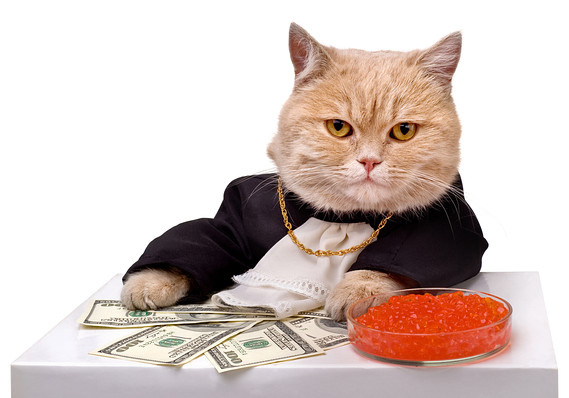

In [ ]:
# get an image of a cat from Internet
img_path = get_image("https://s.marketwatch.com/public/resources/images/MW-BM546_pfcats_MG_20131004154326.jpg", "cat")

# view the image
display(Image.open(img_path))

Start with something easy - only one class makes any sense:

In [ ]:
# possible class labels/class descriptions
text_descrs = ["an oven", "a university", "a cat"]

# perform CLIP classification
probs = do_CLIP_prediction(model, preprocess, img_path, text_descrs)

# print CLIP classification results
print_label_probs(probs, text_descrs)

Label probs:
an oven: 0.00680
a university: 0.00640
a cat: 0.98680


Let's move to more reasonable classes, only the animals:

In [ ]:
# possible class labels/class descriptions
text_descrs = ["a horse", "a dog", "a cat"]

# perform CLIP classification
probs = do_CLIP_prediction(model, preprocess, img_path, text_descrs)

# print CLIP classification results
print_label_probs(probs, text_descrs)


Label probs:
a horse: 0.00301
a dog: 0.02388
a cat: 0.97312


What if we include a more general concept, like *an animal*?

In [ ]:
# possible class labels/class descriptions
text_descrs = ["a horse", "a dog", "a cat", "an animal"]

# perform CLIP classification
probs = do_CLIP_prediction(model, preprocess, img_path, text_descrs)

# print CLIP classification results
print_label_probs(probs, text_descrs)

Label probs:
a horse: 0.00273
a dog: 0.02164
a cat: 0.88206
an animal: 0.09358


We can see that the cat has a lot of money. Try to describe the picture in more detail. Instead of just a class label, let's put some adjectives describing the cat.

In [ ]:
# possible class labels/class descriptions
text_descrs = ["a horse", "a dog", "a cat", "an animal", "a rich cat", "a poor cat"]

# perform CLIP classification
probs = do_CLIP_prediction(model, preprocess, img_path, text_descrs)

# print CLIP classification results
print_label_probs(probs, text_descrs)

Label probs:
a horse: 0.00000
a dog: 0.00001
a cat: 0.00042
an animal: 0.00004
a rich cat: 0.99875
a poor cat: 0.00077


How CLIP works with entire sentences instead of labels? Does it handle negative sentences? 

In [ ]:
# possible class labels/class descriptions
text_descrs = ["This is a cat.", "This is not a cat.", "Perhaps it is a cat."]

# perform CLIP classification
probs = do_CLIP_prediction(model, preprocess, img_path, text_descrs)

# print CLIP classification results
print_label_probs(probs, text_descrs)

Label probs:
This is a cat.: 0.64719
This is not a cat.: 0.30986
Perhaps it is a cat.: 0.04295


But the picture includes not only a cat. We can also see the money and caviar. Which one will be chosen by CLIP? Maybe all of them?

In [ ]:
# possible class labels/class descriptions
text_descrs = ["This is not only a cat, but also money and caviar.", 
               "This is only a cat.", 
               "Only money is visible in the picture.",
               "Money and caviar are there, but there is no cat at all."]

# perform CLIP classification
probs = do_CLIP_prediction(model, preprocess, img_path, text_descrs)

# print CLIP classification results
print_label_probs(probs, text_descrs)

Label probs:
This is not only a cat, but also money and caviar.: 0.59502
This is only a cat.: 0.00001
Only money is visible in the picture.: 0.00001
Money and caviar are there, but there is no cat at all.: 0.40496


Finally, force CLIP to choose a label from a set of labels that are all correct. Compare the probability values with f.e., the first case, where
`text_descrs = ["an oven", "a university", "a cat"]`

In [ ]:
# possible class labels/class descriptions
text_descrs = ["money", 
               "a cat", 
               "a caviar"]

# perform CLIP classification
probs = do_CLIP_prediction(model, preprocess, img_path, text_descrs)

# print CLIP classification results
print_label_probs(probs, text_descrs)

Label probs:
money: 0.60905
a cat: 0.19053
a caviar: 0.20042


### **TODO**: Now it is your turn to challenge the CLIP! Try classifying your own picture of anything (your favorite pet, food, building, ...). Investigate  different NLP supervision variants. 

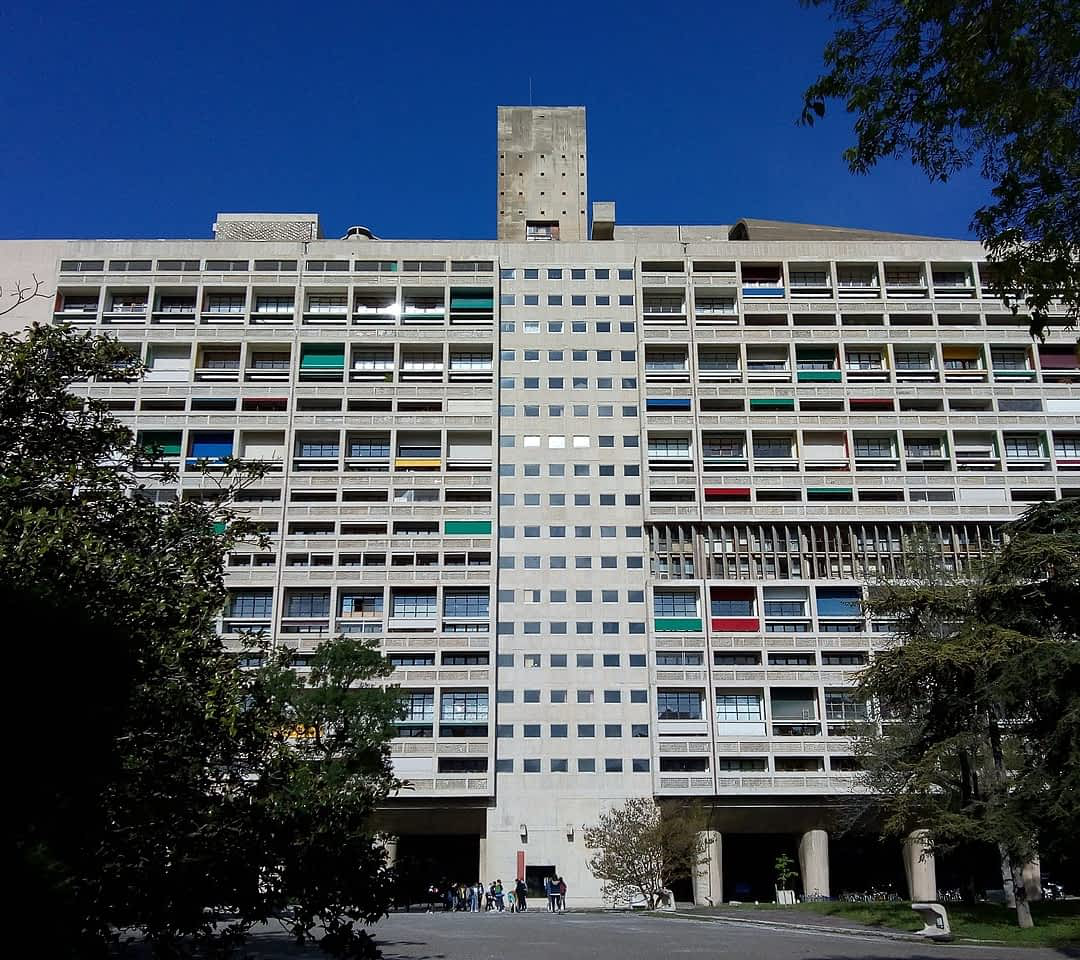

In [ ]:
# TODO: paste some URL from the Internet (first argument) and the filename (second argument)
img_path = get_image("https://s3.eu-central-1.amazonaws.com/pressland-cms/cache/metatags_image/jn/jednostka.jpeg", "building")

# view the image
display(Image.open(img_path))

In [ ]:
# TODO: experiment with various possible labels (put them as strings in the array)
text_descrs = ["a castle", "an apartment building", "a church"]

# perform CLIP classification
probs = do_CLIP_prediction(model, preprocess, img_path, text_descrs)

# print CLIP classification results
print_label_probs(probs, text_descrs)

Label probs:
a castle: 0.01282
an apartment building: 0.98570
a church: 0.00148


# **Task 2:**
Examine the zero-shot prediction for CLIP. We will be working with the CIFAR10 dataset and will try to classify its test images with CLIP without any training! 

**NOTE:** For this task, change the Google Colab environment type to GPU to speed up the calculations.

### Initial setup

In [ ]:
!pip3 install torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import os
import clip
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Functions definitions

In [ ]:
def load_data(preprocess):
  """
  Loads the CIFAR10 dataset. 
  
  Returns train and test parts.
  """
  root = os.path.expanduser("/content")
  train = CIFAR10(root, download=True, train=True, transform=preprocess)
  test = CIFAR10(root, download=True, train=False, transform=preprocess)
  return train, test

In [ ]:
def test_CLIP(dataset, class_labels):
  """
  Performs CLIP predictions for dataset images. Argument class_labels represents the class labels/descriptions.

  Returns the true label indices and predicted label indices.
  """

  y = []
  y_hat = []

  # extract all labels present in the dataset and transform them to labels
  all_texts = torch.cat([clip.tokenize(c) for c in class_labels]).to(device)
  with torch.no_grad():
    for images, labels in tqdm(DataLoader(dataset, batch_size=500)):
      logits_per_image, logits_per_text = model(images.to(device), all_texts)
      probs = logits_per_image.softmax(dim=-1).cpu().numpy()
      y.append(labels.numpy())
      y_hat.append(np.argmax(probs, axis=1))
    
  return np.concatenate(y), np.concatenate(y_hat)

In [ ]:
def calc_accuracy(y, y_hat):
  """
  Calculate and prints the accuracy. y represents true label indices and y_hat - predicted label indices. 
  """
  acc = np.mean(y == y_hat)
  print(f'Accuracy on testset: ' + '{0:.2f}'.format(acc*100)+'%')

In [ ]:
def plot_confusion_matrix(y, y_hat, class_labels, annotations = True):
  """
  Plots confusion matrix. y represents true label indices and y_hat - predicted label indices. If annotations is set to True, the confusion matrix will include numeric values. 
  """
  cf_matrix = confusion_matrix(y, y_hat)

  fig, ax = plt.subplots(figsize=(10,8))
  sns.heatmap(cf_matrix, annot=annotations, cmap='Blues', ax = ax, fmt='g')

  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')

  ax.xaxis.set_ticklabels(class_labels, rotation='vertical')
  ax.yaxis.set_ticklabels(class_labels, rotation='horizontal')

  plt.show()

### Perform zero-shot CLIP classification for CIFAR10

In [ ]:
# load the model and dataset
model, preprocess = clip.load('ViT-B/32', device)
_, testset = load_data(preprocess)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 63.7MiB/s]


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [ ]:
# extract class labels 
class_labels = [f"a {c}" for c in testset.classes]

# predict class labels for the testset
y, y_hat = test_CLIP(testset, class_labels)

100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


### Investigate the results of zero-shot CLIP classification
Print the accuracy obtained on the testset and the confusion matrix.

In [ ]:
# calculate accuracy on the testset
calc_accuracy(y, y_hat)

Accuracy on testset: 88.65%


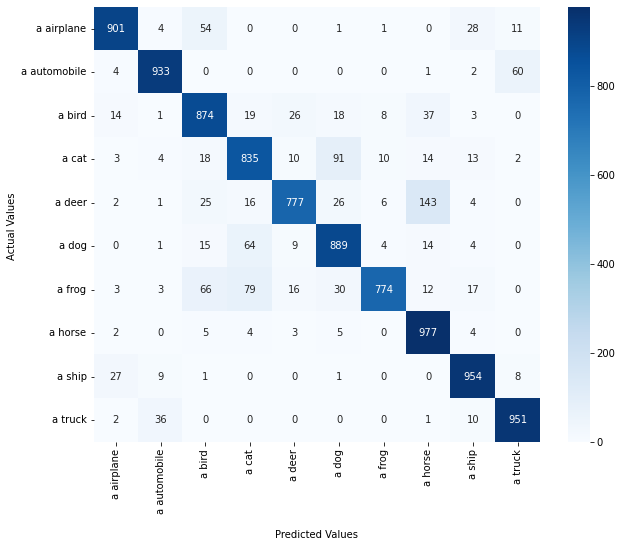

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(y, y_hat, class_labels)

### **TODO:** Experiment with different class labels and again check how different variants of NLP supervision influence CLIP accuracy! Check the accuracy and confusion matrix for each variant.

You can, for example, replace labels with whole sentences, like: 

*cat* --> *This is a picture of a cat.*

or add some adjectives to the nouns.

In [ ]:
# TODO: extract class labels 
class_labels = [f"This is a picture of a {c}" for c in testset.classes]

# predict class labels for the testset
y, y_hat = test_CLIP(testset, class_labels)

100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


In [ ]:
# calculate accuracy on the testset
calc_accuracy(y, y_hat)

Accuracy on testset: 89.38%


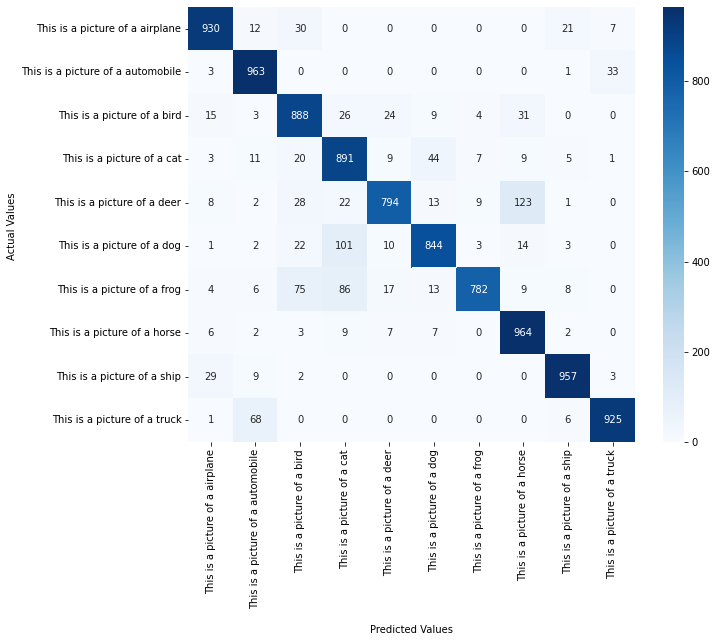

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(y, y_hat, class_labels)

### **TODO:** Try another dataset, for example CIFAR100. 
CIFAR10 contains only 10 classes and CIFAR100 - 100. Comapare the zero-shot CLIP accuracy for CIFAR10 and CIFAR100.

In [ ]:
from torchvision.datasets import CIFAR100

def load_data_cifar100(preprocess):
  root = os.path.expanduser("/content")
  train = CIFAR100(root, download=True, train=True, transform=preprocess)
  test = CIFAR100(root, download=True, train=False, transform=preprocess)
  return train, test

In [ ]:
_, testset = load_data_cifar100(preprocess)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /content/cifar-100-python.tar.gz to /content
Files already downloaded and verified


100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


Accuracy on testset: 60.24%


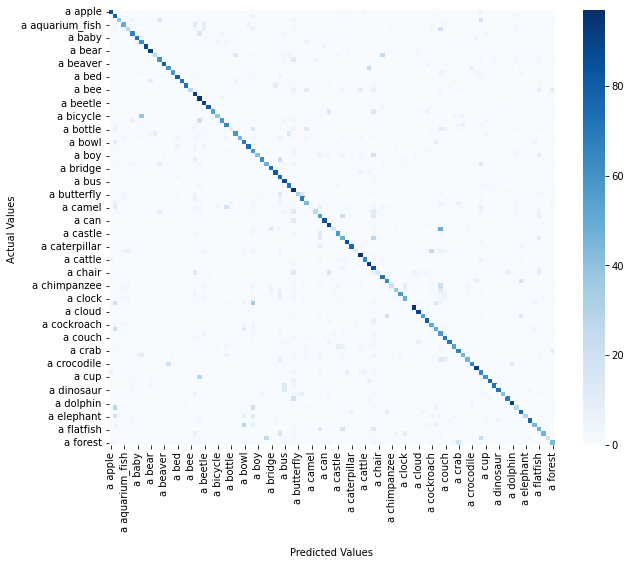

In [ ]:
class_labels = [f"a {c}" for c in testset.classes]

y, y_hat = test_CLIP(testset, class_labels)

calc_accuracy(y, y_hat)
plot_confusion_matrix(y, y_hat, class_labels, annotations=False)

# **Exercise**
### **TODO**: Use CLIP as a feature extractor. On the extracted features, use a simple classifier, like logistic regression, SVM, or kNN. Compare results with CLIP without supervision. 

In [ ]:
!pip3 install torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import os
import clip
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm
from sklearn import preprocessing

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def load_data(preprocess):
  root = os.path.expanduser("/content")
  train = CIFAR10(root, download=True, train=True, transform=preprocess)
  test = CIFAR10(root, download=True, train=False, transform=preprocess)
  return train, test

In [ ]:
def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [ ]:
# load the model and dataset
model, preprocess = clip.load('ViT-B/32', device)
train, test = load_data(preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Scale features
scaler = preprocessing.StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.


100%|██████████| 100/100 [00:21<00:00,  4.74it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


In [ ]:
print(f"CLIP features & Logistic regression classifier accuracy = {accuracy:.2f}%")

CLIP features & Logistic regression classifier accuracy = 94.38%
